# A5 Problems

### Problem 1

In this problem we have a charged cylindrical conductor held at potential $V$ inside a box where the walls are held at $V = 0$. We first want to use a relaxation solver to find the potential everywhere in space.

Recall from Maxwell's equations:
$$\vec{\nabla} \cdot \vec{E} = \frac{\rho}{\epsilon_0}$$
And recall the equation for static potentials:
$$\vec{E} = -\vec{\nabla} V$$
Combining the two equations and taking $\rho$ in units where $\epsilon_0 = 1$ to ease computation, we arrive at
$$\nabla^2 V = -\rho$$
which is just Poisson's equation.

We'll setup the cylinder to be in the middle of a box, and the lengthwise direction of the cylinder to be the $z$ direction. Given that the solution in constant $z$ slices will be symmetric for a long cylinder, this problem reduces to two dimensions, and we can solve 

Now let's linearize Poisson's equation by taking estimates for the second derivative as usual. The problem is posed in a box, but there is cylindrical symmetry along the axis of the cylinder. So, we can reduce the problem in two dimensions, and consider constant $z$ slices along the cylinder:
$$\nabla^2 V \approx \frac{V(x+h, y) + V(x-h, y) - 2V(x, y)}{h^2} + \frac{V(x, y+h) + V(x, y-h) - 2V(x, y)}{h^2} = -\rho$$

Rearranging to solve for our potential $V(x, y, z)$:
$$V(x, y) = \frac{1}{4}\left( V(x+h, y, z) + V(x-h, y, z) + V(x, y+h, z) + V(x, y-h, z) + h^2 \rho\right)$$

So essentially this is saying $V(x,y)$ is the average of the surrounding points, plus some contribution from the source term $\rho$.

With this in mind, the relaxation method basically just goes as follows:
- Take all of your points where the potential isn't already defined
- Average the surrounding points & the source term contribution to update the point
- Continue this iteration process until the change in your prediction is small

We'll keep in mind a couple things while we do this:
- We can make the process of averaging very fast with smart use of numpy arrays
- Since our potential is defined on the cylinder (which in our problem is the only place we have a contribution from the charge density $\rho$), we don't actually need to add a contribution from it anywhere

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit

First we need to setup our grid

In [2]:
# We'll define our box resolution to be nxn
#n = 64
n=256
# We'll define the radius of the circle in the box to be n//8
# (recall // is integer division in python 3!)
R = n//8
# I'll make a grid of (x, y) points going from -n//2 to n//2
X, Y = np.meshgrid(
    np.linspace(-1*(n//2), n//2, n), np.linspace(-1*(n//2), n//2, n)
)
# And define the vector r for each of the (x,y) point pairs
r = np.sqrt(X**2 + Y**2)
# We'll also define a "radius" for the box, for use later in the analytical
# solution. Here I choose the radius to be the distance to the box corner
# from the centre.
r_box = n/np.sqrt(2)

In [3]:
# Now we'll make a grid to populate with potential values. First we'll just
# set up the cylinder set to potential V_0=1, and later we'll populate with
# averaging
V_0 = 1
V_original = np.zeros(X.shape)
cylinder_mask = np.where(r <= R)
V_original[cylinder_mask] = V_0

Let's take a look at our boundary conditions to maker sure everything looks good

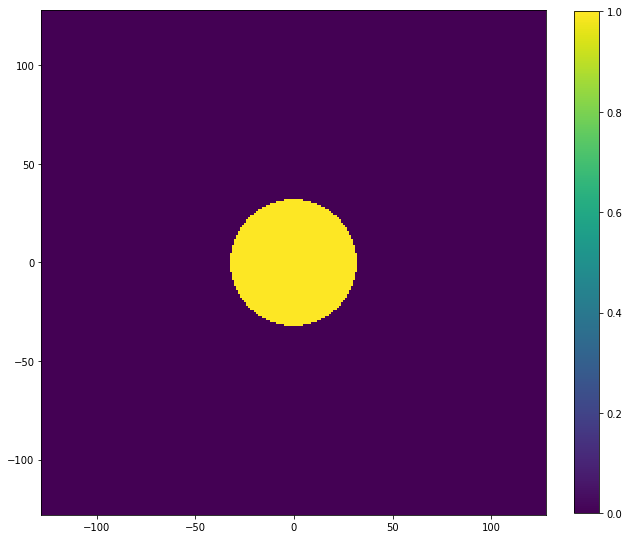

In [4]:
rcParams['figure.figsize'] = (10,10)
plt.imshow(V_original, origin="lower", extent=(-1*(n//2), n//2, -1*(n//2), n//2))
plt.colorbar(fraction=0.045)
plt.show()

Alright, we have a slice of a cylinder! Great. Now we'll define a function to iterate through the relaxation method `n_iter` times. I'll do this by making copies of the potential array by rolling the surrounding grid points into the grid cell I want to find the average, and then taking that average by simpling adding the arrays and dividing by 4.

I'll also define a tolerance in this function, which basically says that if the difference in my potential after an iteration is on average less than the tolerance, I'll say that I've converged to the solution.

In [5]:
def relaxation(V, n_iter, cylinder_mask, tolerance=None):
    '''
    A function which takes a potential grid V and solves for the potential field
    given V initially has proper boundary conditions by relaxing n_iter times.
    
    PARAMETERS:
    -----------
    V : numpy array
        The initial potential field to relax, with proper boundary conditions for
        this problem
    n_iter : int
        The number of times to iterate through the relaxation method
    cylinder_mask : array-like
        The central mask for our problem to set to V_0
    tolerance : float, optional
        The tolerance to iterate to. Here tolerance is defined as the mean of the
        difference between the current and previous iteration across the whole grid
        
    RETURNS:
    --------
    V : numpy array
        The solution for the potential field after iterating
    '''
    for i in range(n_iter):
        # Here I make copies of my potential array shifted by one unit up/right 
        # (p for plus) in x/y and one unit down/left (m for minus) in x/y.
        # np.roll ends up setting the -1 index to 0, so to avoid that problem
        # I set the boundaries to nans after rolling. These arrays put the 
        # surrounding blocks to the point I want to average in that block
        # itself, so finding the average becomes a simple average!
        V_py = np.roll(V, 1, axis=0)
        V_py[0,:] = np.nan
        V_my = np.roll(V, -1, axis=0)
        V_my[-1,:] = np.nan
        V_px = np.roll(V, 1, axis=1)
        V_px[:,0] = np.nan
        V_mx = np.roll(V, -1 ,axis=1)
        V_mx[:,-1] = np.nan
        
        # Make a copy of the previous iteration before updating
        V_old = V.copy()

        # Take the mean to update the potential array
        V = np.nansum(np.dstack((V_py, V_my, V_px, V_mx)),2)/4
        
        # Re-integrate boundary conditions, just in case!
        V[cylinder_mask] = 1
        V[0,:] = 0
        V[-1,:] = 0
        V[:, 0] = 0
        V[:, -1] = 0
        
        if tolerance:
            mean_diff = np.mean(abs(V - V_old))
            if mean_diff < tolerance:
                print("Change in potential within tolerance after {} iterations".format(i+1))
                break
                
    return V

Let's set a tolerance of $10^{-6}$ to test our solution, assuming we'll get there within at least $10^5$ iterations

In [6]:
V_relax = relaxation(np.zeros((n,n)), int(1e5), cylinder_mask, tolerance=1e-6)

Change in potential within tolerance after 18960 iterations


In [7]:
# Write a quick function for plotting
def plot_potential(V, title, cmap='viridis'):
    plt.imshow(V, origin="lower", extent=(-1*(n//2), n//2, -1*(n//2), n//2), cmap=cmap)
    plt.xlabel("$x$", fontsize=24)
    plt.ylabel("$y$", fontsize=24)
    plt.title(title, fontsize=20)
    cb = plt.colorbar(fraction=0.045)
    plt.show()

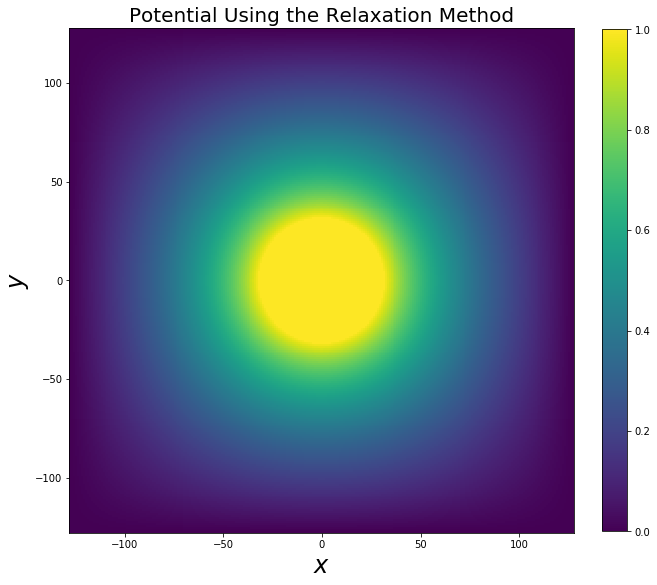

In [8]:
plot_potential(V_relax, "Potential Using the Relaxation Method")

Nice, that looks about like what I would have expected for the problem setup. We can actually (kind of) solve this problem analytically too. Given we know the electric field is:

$$E = \frac{\lambda}{2\pi \epsilon_0 r}$$

we can construct the potential given our boundary conditions by integrating (I'm also going to set $\epsilon_0 = 1$):

$$V = -\int \vec{E} \cdot \vec{dr}$$
$$V = \frac{\lambda}{2\pi} \ln r + C$$

Now we have our boundary conditions which can solve for the degrees of freedom in $V$: $V(r=r_c) = V_0$ ($r_c$ is the radius of the cylinder) and $V(r=r_{box}) = 0$. However, now begins the problem of what I mean by "kind of" solve the problem above: our boundary condition for the box isn't well defined in spherical coordinates because it's a square box, not a circular box! Thus later we'll have to make some decision as to what $r_{box}$ is when we compare our numerical solution to the analytic one. Anyways, taking these two boundary conditions into account we get two equations:

$$0 = \frac{\lambda}{2\pi} \ln r_{box} + C$$
$$V_0 = \frac{\lambda}{2\pi} \ln r_c + C$$

Taking the difference of the two:

$$V_0 = \frac{\lambda}{2\pi} \ln\left(\frac{r_c}{r_{box}}\right)$$
$$\implies \lambda = \frac{2\pi V_0}{\ln\left(\frac{r_c}{r_{box}}\right)}$$

Which leads to:

$$\implies C = \frac{-V_0 \ln(r_{box})}{\ln\left(\frac{r_c}{r_{box}}\right)}$$
$$\implies V = \frac{V_0}{\ln\left(\frac{r_c}{r_{box}}\right)} \left( \ln\left(\frac{r}{r_{box}}\right) \right)$$

Knowing this, let's see what the analytic solution looks like and compare our solution. I'll set $r_{box}$ as the distance from the centre of the box to the corner.

In [9]:
r_box = n/np.sqrt(2)

In [10]:
λ = 2*np.pi*V_0/np.log(R/r_box)
C = -V_0*np.log(r_box)/np.log(R/r_box)
V_analytic = λ*np.log(r)/(2*np.pi) + C
V_analytic[cylinder_mask] = 1

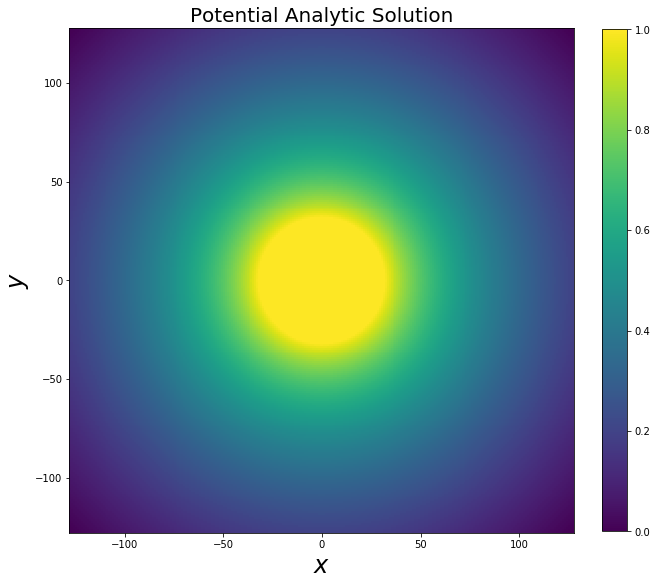

In [11]:
plot_potential(V_analytic, "Potential Analytic Solution")

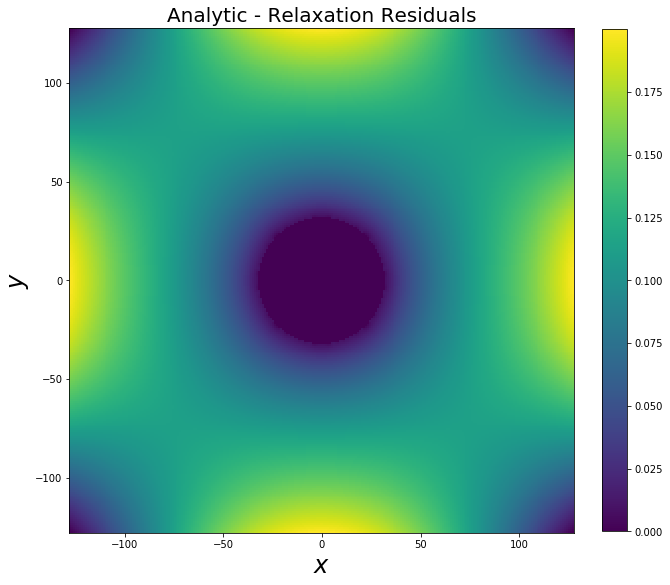

In [12]:
plot_potential(V_analytic - V_relax, "Analytic - Relaxation Residuals")

As we can see, there's quite a bit of residual structure in our analytic solution compared to our numerical solution -- this is from the issue of a circular boundary condition on a square box! We can alternatively fit $\lambda$ and $C$ since we know the form of $V(r)$:

In [13]:
# Taking a 1D slice from the edge of the cylinder to the edge of the box
V_1d = V_relax[n//2 + n//8,:n//2:]
r_1d = r[n//2 + n//8,:n//2:]

In [14]:
def f_log(x, λ, C):
    return λ*np.log(x)/(2*np.pi) + C

In [15]:
# Using curve fit to get parameters for my 
popt, pcov = curve_fit(f_log, r_1d, V_1d)

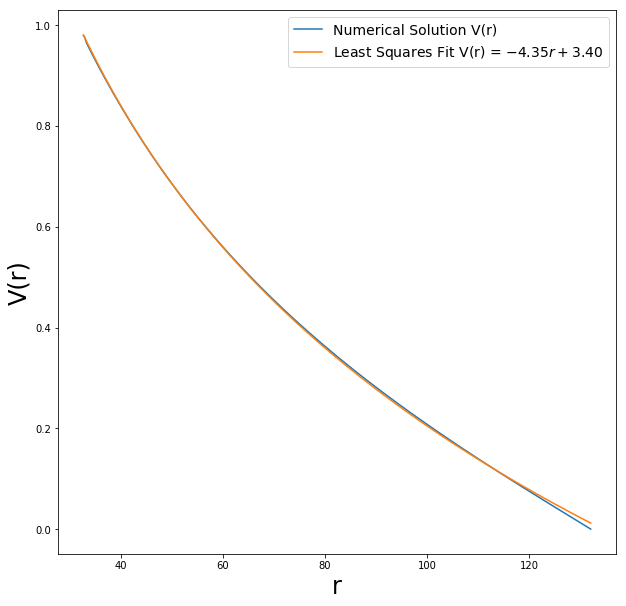

In [16]:
plt.plot(r_1d,V_1d, label="Numerical Solution V(r)")
plt.plot(r_1d, f_log(r_1d, *popt), label="Least Squares Fit V(r) = $%.2fr + %.2f$" % (popt[0],popt[1]))
plt.xlabel("r", fontsize=24)
plt.ylabel("V(r)", fontsize=24)
plt.legend(fontsize=14)
plt.show()

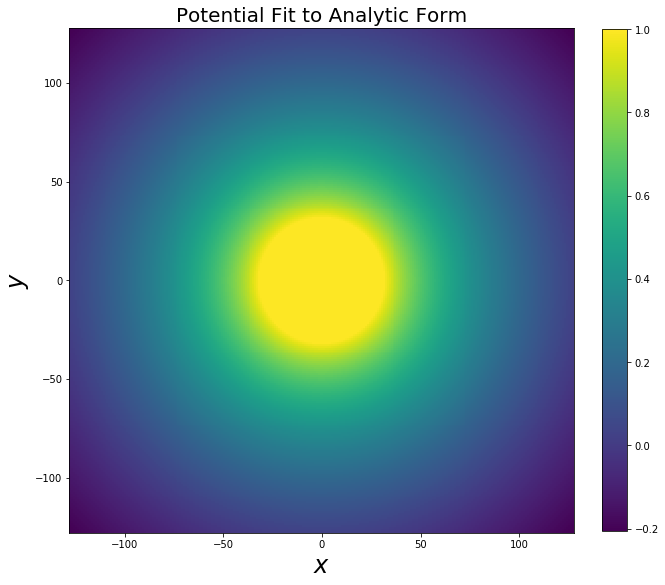

In [17]:
V_fit = f_log(r, *popt)
V_fit[cylinder_mask] = 1
plot_potential(V_fit, "Potential Fit to Analytic Form")

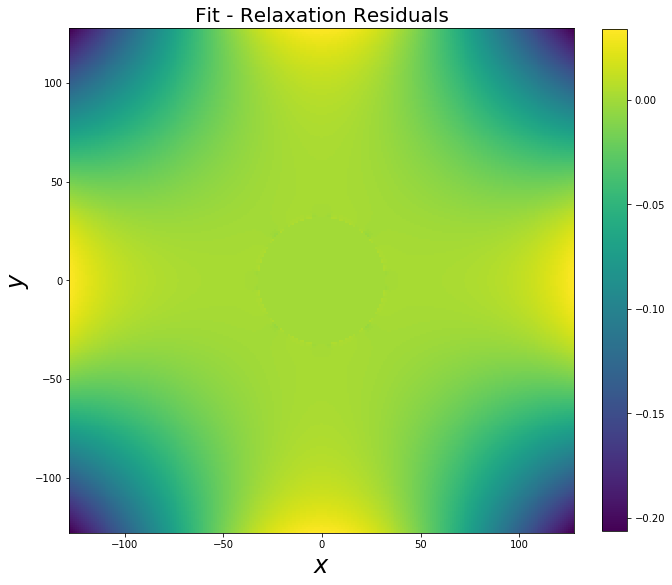

In [18]:
plot_potential(V_fit - V_relax, "Fit - Relaxation Residuals")

In [19]:
print("Mean analytic residual with r_box = centre to corner distance: %.3f" % (np.mean(abs(V_relax - V_analytic))))
print("Mean fit residual: %.3f" % (np.mean(abs(V_relax - V_fit))))

Mean analytic residual with r_box = centre to corner distance: 0.105
Mean fit residual: 0.026


Alright, overall fitting for $\lambda$ and $C$ does a slightly better job than our choice of $r_{box}$ allowed, but there is still significant structure as a result of our grid being square. But that's ok! We can probably trust our solution knowing that this is where the differences from the analytic solution spur from.

### Problem 2

Now we need to not just use the relaxation method to solve the problem, but the [conjugate gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method) method. The conjugate gradient method is an algorithm that solves systems of linear equations whose matrices are symmetric and positive-definite. These situations are often the case when solving PDEs. The method goes as follows:
- We want to solve the system of linear equations $Ax = b$
- To do this iteratively, we'll construct a set of basis vectors $p_k$ which are mutually conjugate
- Our first basis vector $p_0$ will be the residual residual of our initial guess $p_0 = b - Ax_0$
- We'll step in the direction of this basis vector by saying $x_{k+1} = x_k + \alpha_k + p_k$ where:
$$\alpha_k = \frac{p_k^T r_k}{p_k^TAp_k}$$
- Compute new residuals $r_{k+1} = r_k - \alpha_k A p_k$ and step in a mutually conjugate direction $p_{k+1} = r_{k+1} + \beta_k p_k$ where:
$$\beta_k = \frac{r_{k+1}^T r_{k+1}}{r_k^Tr_k}$$
- Repeat until residuals are sufficiently small

The methodology of doing this is fairly clear, we just need to make sure we define well what we mean by $Ax = b$ in our context. Here, $A$ is our operator, $x$ is the solution we desire (in our case, the potential), and $b$ is anything that is known. Thus in our case, $Ax$ is like $\nabla^2 V$ and $b$ are the boundary conditions, which are the only knowns in our problem. Using our linearized $\nabla^2$, $Ax$ essentially becomes the matrix described by:
$$V(x_{i+1}, y_i) + V(x_{i-1}, y_i) + V(x, y_{i+1}) + V(x, y_{i-1}) - 4V(x, y)$$
(taking our steps in each direction $h$ from before to be one unit). 

Note that this assumes all of the surrounding points are unknowns. In the case that, say, $x_{i+1}$ is a known boundary condition, that would contribute instead to $b$, and we would have:
$$V(x_{i-1}, y_i) + V(x, y_{i+1}) + V(x, y_{i-1}) - 4V(x, y) = V(x_{i+1}, y)$$

Also note that if there was any other source contribution $\rho$ we knew about that wasn't defined by the boundary conditions like in our case, that would also contribute to $b$.

In [20]:
# Make an array of our boundary conditions
bc = np.zeros(V_original.shape)
bc[cylinder_mask] = 1

In [21]:
def make_Ax(V, cylinder_mask):
    '''
    Make the Ax matrix, making sure to properly mask regions with our 
    boundary conditions
    
    PARAMETERS:
    -----------
    V : array-like
        The array of values for the potential on the current iteration
    cylinder_mask : array-like
        The central mask for our problem to set to V_0
        
    RETURNS:
    --------
    Ax : array-like
        The Ax matrix for use in the conjugate gradient method
    '''
    # Rolling the array as in the relaxation method to quickly
    # sum the set of matrices
    V_roll = V.copy()
    V_roll[cylinder_mask] = 0
    V_py = np.roll(V_roll, 1, axis=0)
    V_py[0,:] = 0
    V_my = np.roll(V_roll, -1, axis=0)
    V_my[-1,:] = 0
    V_px = np.roll(V_roll, 1, axis=1)
    V_px[:,0] = 0
    V_mx = np.roll(V_roll, -1 ,axis=1)
    V_mx[:,-1] = 0
    Ax = (V_px + V_mx + V_py + V_my )/4.0 - V
    return Ax

def make_b(bc):
    '''
    Make the b matrix (appearing on the rhs of the equation) given a 
    set of boundary conditions
    
    PARAMETERS:
    -----------
    bc : array-like
        The array of values representing our boundary conditions for this
        problem
        
    RETURNS:
    --------
    b : array-like
        The b matrix for use in the conjugate gradient method
    '''
    bc_py = np.roll(bc, 1, axis=0)
    bc_py[0,:] = 0
    bc_my = np.roll(bc, -1, axis=0)
    bc_my[-1,:] = 0
    bc_px = np.roll(bc, 1, axis=1)
    bc_px[:,0] = 0
    bc_mx = np.roll(bc, -1 ,axis=1)
    bc_mx[:,-1] = 0
    b = -1*(bc_px + bc_mx + bc_py + bc_my)/4.0
    return b

def conjugate_gradient(V, cylinder_mask, bc, niter, tolerance=None):
    '''
    Perform the conjugate gradient method until a given tolerance is met
    
    PARAMETERS:
    -----------
    V : array-like
        The array of values for the potential on the current iteration
    cylinder_mask : array-like
        The central mask for our problem to set to V_0
    bc : array-like
        The array of values representing our boundary conditions for this
        problem
    niter : int
        The maximum number of conjugate gradient iterations to perform
    tolerance : float, optional
        None by defeault. If a float is given, iterate until the mean
        difference between subsequent iterations is within the tolerance
        
    RETURNS:
    --------
    x : array-like
        The resulting potential from the method
    '''
    x = V.copy()
    b = make_b(bc)
    Ax = make_Ax(x, cylinder_mask)
    r = b - Ax
    p = r.copy()
    for i in range(niter):
        Ap = make_Ax(p, cylinder_mask)
        rsqr = np.sum(r*r)
        α = rsqr/(np.sum(Ap*p))
        x = x + α*p
        r = r - α*Ap
        β = np.sum(r*r)/rsqr
        p = r + β*p
        if tolerance:
            if rsqr < tolerance:
                print("Change in potential within tolerance after {} iterations".format(i+1))
                break
    return x

Now that we've made all our functions, we just need to quickly apply them and see the result!

Change in potential within tolerance after 257 iterations


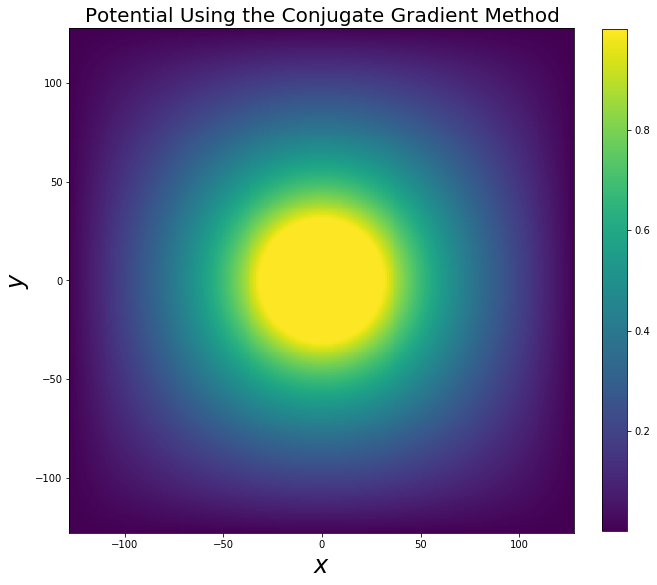

In [22]:
V_cg = conjugate_gradient(np.zeros((n,n)), cylinder_mask, bc, 1000, tolerance=1e-6)
plot_potential(V_cg, title="Potential Using the Conjugate Gradient Method")

Wow, the amount of iterations to reach a solution for the conjugate gradient method is much less! It took 257 iterations for conjugate gradient, and 18960 iterations for our basic relaxation -- that's a huge improvement! Note that we do have to apply a bunch of matrix operations in conjugate gradient, so each iteration probably takes a notable amount of time longer, but the time save is still huge.

### Problem 3

Now we want to update our solver to work on a range of resolutions. To do this, we'll start by downsampling our grid to be coarse, evaluating the boundary conditions on that grid, solving the problem, then interpolating to a higher resolution, using that solution as an initial condition, and repeating until the resolution we want is met. I'll be downsampling and upsampling the grid by factors of two, so to most efficiently resample it is best to make $n\times n$ grids where $n$ is a power of 2.

In [23]:
def downsample_matrix(matrix):
    """
    A simple function to downsample a matrix. Note that your matrix shape should be
    divisible by two for this to work best. Also note that this works best for 
    positive potential fields, as if you had negative potentials, you would be taking
    the "least negative" value in the region you're sampling as opposed to the 
    most negative.
    
    PARAMETERS:
    -----------
    matrix : array-like
        The array of values for the potential on the current resolution
        
    RETURNS:
    --------
    new_matrix : array-like
        The potential array downsampled by a factor of two
    """
    new_matrix = np.zeros([matrix.shape[0]//2, matrix.shape[1]//2], dtype=matrix.dtype)
    new_matrix = np.maximum(new_matrix, matrix[::2,::2])
    new_matrix = np.maximum(new_matrix,matrix[::2,1::2])
    new_matrix = np.maximum(new_matrix,matrix[1::2,::2])
    new_matrix = np.maximum(new_matrix,matrix[1::2,1::2])
    return new_matrix

def upsample_matrix(matrix):
    """
    Quickly upsample your matrix by a factor of two by just copying values 
    and filling into an upsampled matrix
    
    PARAMETERS:
    -----------
    matrix : array-like
        The array of values for the potential on the current resolution
        
    RETURNS:
    --------
    new_matrix : array-like
        The potential array upsampled by a factor of two
    """
    new_matrix = np.zeros([matrix.shape[0]*2,matrix.shape[1]*2],dtype=matrix.dtype)
    new_matrix[::2,::2] = matrix
    new_matrix[::2,1::2] = matrix
    new_matrix[1::2,::2] = matrix
    new_matrix[1::2,1::2] = matrix
    return new_matrix

Also make a recursive function which goes through the conjugate gradient at some initial boxsize, then upsamples by a factor of two until the desired size `n_total` is reached.

In [24]:
def cg_iter(n_total, n_start, V_init=None, V_0=1, p4=False, plot=True):
    """
    Iterate through the conjugate gradient method, starting with a grid
    sized n_start x n_start, and upsampling -> solving until the desired
    solution at n_total x n_total is reached.
    
    PARAMETERS:
    -----------
    n_total : int
        The final resolution to be solved after series of upsampling
    n_start : int
        The initial resolution to solve
    V_init : array-like, optional
        The initial parameters to start from, which will then be upsampled.
        Used to make this function recursive
    V_0 : float, optional
        The value to use for the central boundary condition of potential
    p4 : bool, optional
        False by default, set True if solving problem 4
    plot : bool, optional
        Plot the iterations as they are solved
        
    RETURNS:
    --------
    V_cg : array-like
        The final solution after rounds of sampling
    """
    print("Sidelength of this iteration: {}".format(n_start))
    R = n_start//8

    X, Y = np.meshgrid(
        np.linspace(
            -1*(n_start//2), 
            n_start//2, 
            n_start
        ), 
        np.linspace(
            -1*(n_start//2),
            n_start//2,
            n_start
        )
    )

    r = np.sqrt(X**2 + Y**2)
    r_box = n_start/np.sqrt(2)
    
    if V_init is None:
        V_original = np.zeros(X.shape)
        
    else:
        V_original = upsample_matrix(V_init)
    
    if not p4:
        cylinder_mask = np.where(r <= R)
    else:
        R2 = int(R*0.2) if int(R*0.2) > 1 else 1
        r2 = np.sqrt((X - R2 - n_start//9)**2 + Y**2)
        cylinder_mask = np.where(
            np.logical_or(r < R, r2 < R2)
        )
    V_original[cylinder_mask] = V_0

    bc = np.zeros(V_original.shape)
    bc[cylinder_mask] = V_0
    
    if V_init is None:
        V_cg = conjugate_gradient(np.zeros((n_start,n_start)), cylinder_mask, bc, 10000, tolerance=1e-6)
    else:
        V_cg = conjugate_gradient(V_original, cylinder_mask, bc, 10000, tolerance=1e-6)
    if plot:
        plot_potential(V_cg, title="Potential Using the Conjugate Gradient Method")
    
    if n_total == n_start:
        return V_cg
    else:
        return cg_iter(n_total, n_start*2, V_init=V_cg,  p4=p4)

Sidelength of this iteration: 16
Change in potential within tolerance after 21 iterations


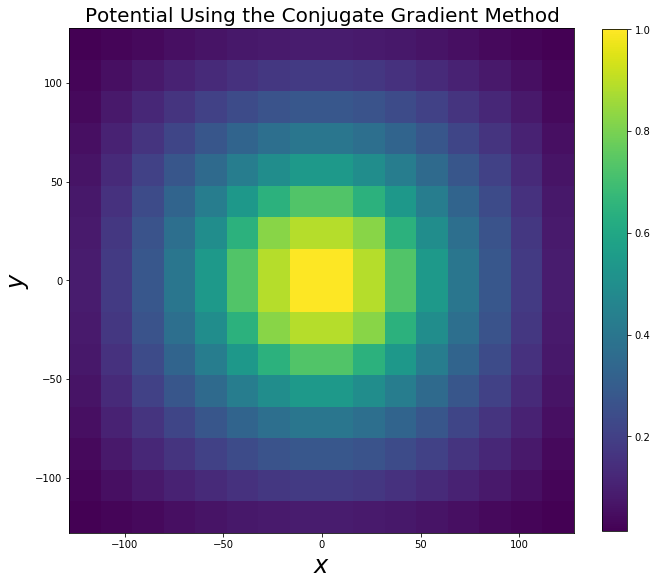

Sidelength of this iteration: 32
Change in potential within tolerance after 29 iterations


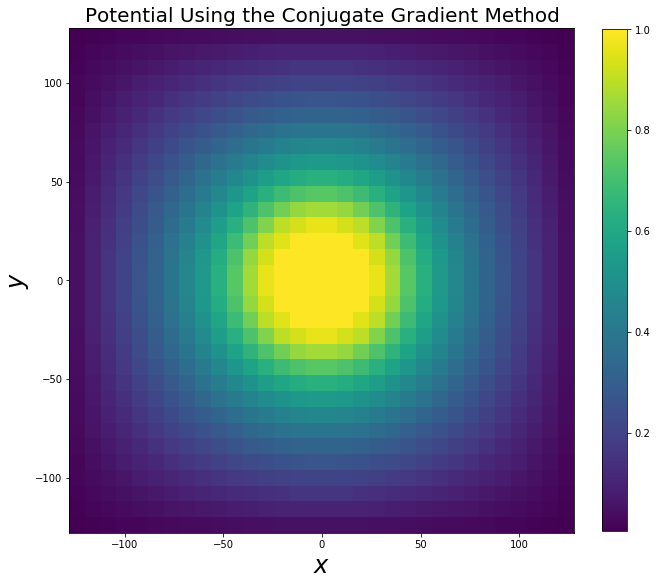

Sidelength of this iteration: 64
Change in potential within tolerance after 37 iterations


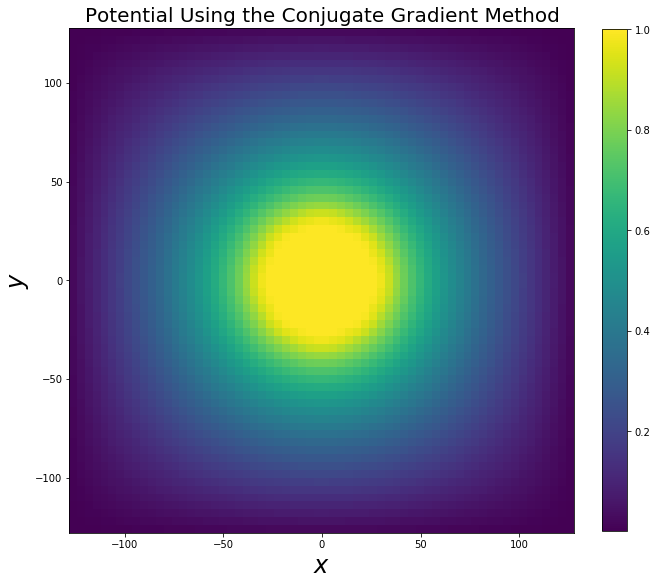

Sidelength of this iteration: 128
Change in potential within tolerance after 51 iterations


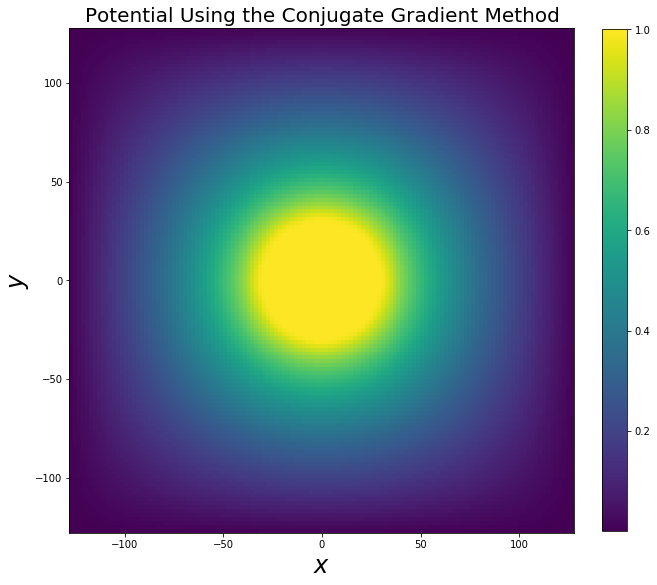

Sidelength of this iteration: 256
Change in potential within tolerance after 76 iterations


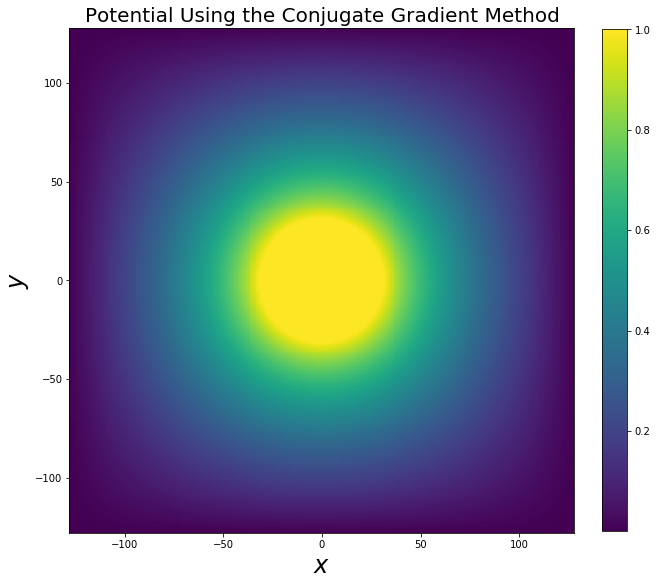

In [25]:
V_cg_iter = cg_iter(256, 16, V_init=None)

Awesome! This method ended up being even faster than conjugate gradient alone. Note that, even if there are more total iterations including each recursive call, an iteration becomes more expensive the larger the grid is, so saving iterations on the largest grid is really all that matters here. Thus, we get ~76 (+ previous iterations' work) iterations for the downsampling method as opposed to 257 iterations for conjugate gradient alone.

# Problem 4

Alright, now that we have a solver that works well, we are going to add a bump to the wire and see what impact that has on the electric field. To characterize the bump, another circle is added when calling `True` with the `p4` boolean in our function, offset to the right edge of the initial circle boundary condition. These boundary condition changes are then propogated through our other functional calls.

Sidelength of this iteration: 16
Change in potential within tolerance after 24 iterations


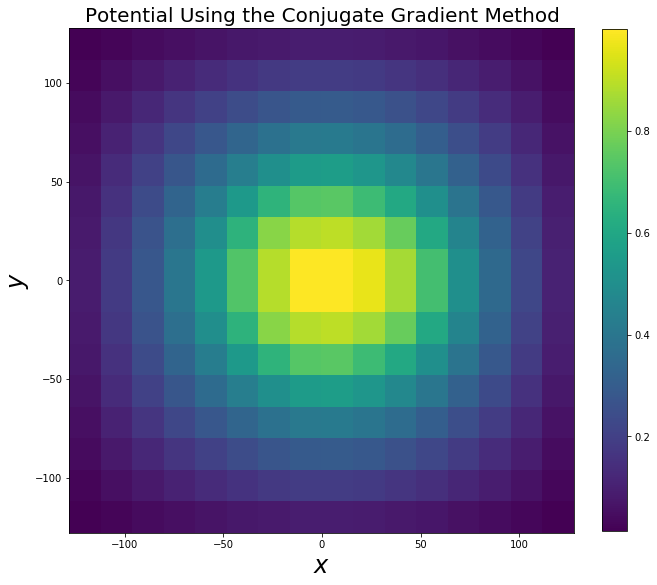

Sidelength of this iteration: 32
Change in potential within tolerance after 28 iterations


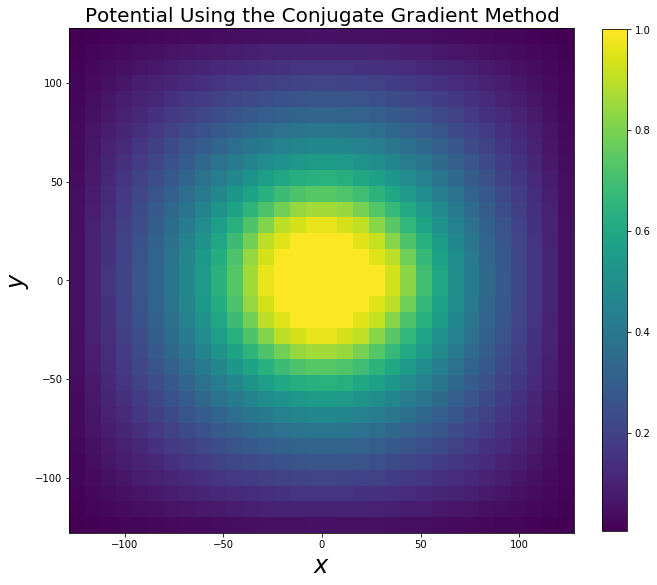

Sidelength of this iteration: 64
Change in potential within tolerance after 42 iterations


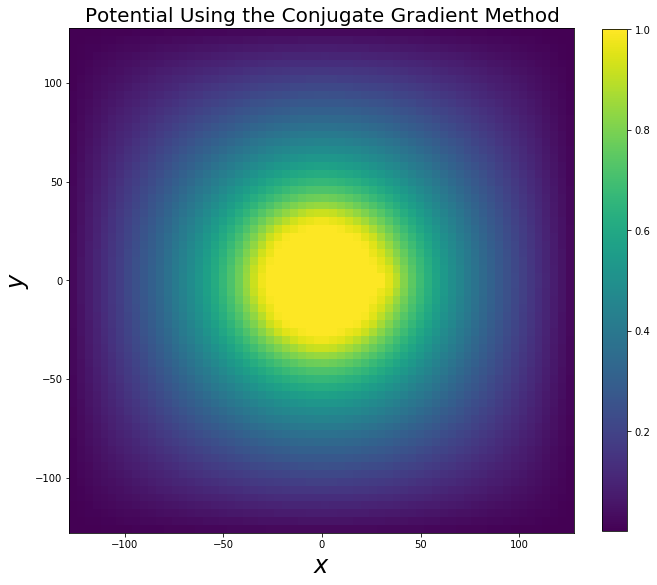

Sidelength of this iteration: 128
Change in potential within tolerance after 78 iterations


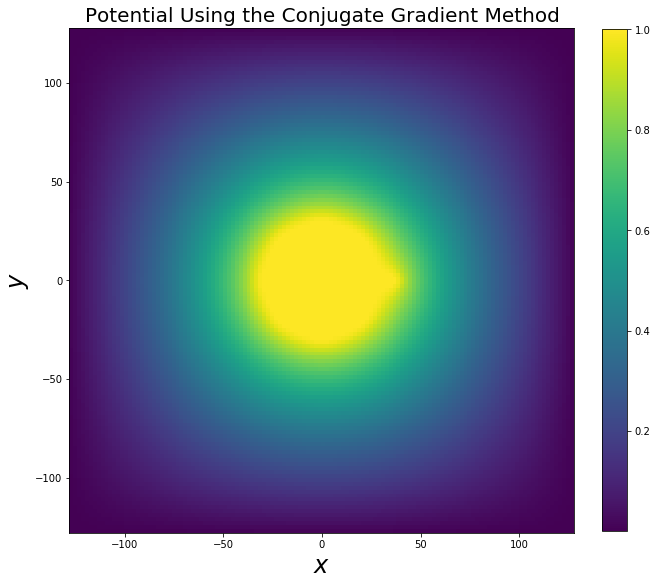

Sidelength of this iteration: 256
Change in potential within tolerance after 72 iterations


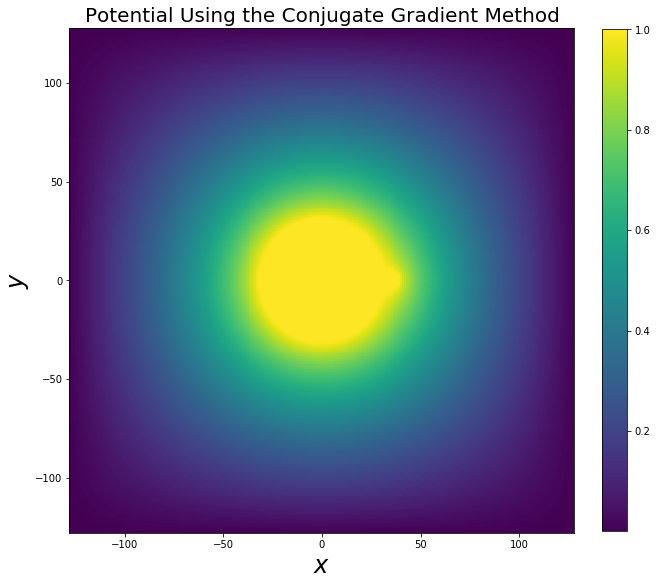

In [26]:
V_cg_p4 = cg_iter(256, 16, V_init=None, p4=True)

Take the gradient to nab the electric field

In [27]:
E_x, E_y = np.gradient(V_cg_p4)

Now Plot the magnitude of the electric field and see what our result is

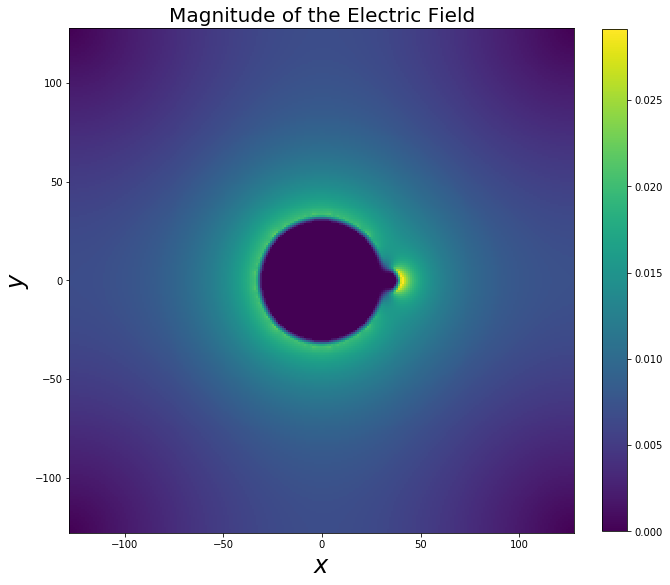

In [28]:
plot_potential(np.sqrt(E_x**2 + E_y**2), "Magnitude of the Electric Field")

We can see there's a big spike in electric field strength at the surface of the bump! Makes sense that power companies want to keep their wires smooth, so as to avoid regions of high electric field that could prove dangerous.

# Problem 5

The heat equation is:
$$\dot{T} = \alpha \nabla^2 T$$
Where I am using compact dot notation to represent a time derivative, $\alpha$ is the diffusion constant, and $T$ is the temperature at point (x, y, z, t).

Let's discretize this in 2D so we can figure out how to solve this PDE. I'll use the $k$ index for time, and $i$, $j$ indices for $x$, $y$ positions in the box grid.

Our equation becomes, using standard finite differencing and taking our grid spacing to be one unit:
$$\frac{T^{k+1}_{i,j} - T^{k}_{i,j}}{\Delta t} = \alpha \left( T^k_{i, j-1} + T^k_{i, j+1} + T^k_{i-1, j} + T^k_{i+1, j} - 4T^k_{i,j}\right)$$

With a bit of grouping, solving for our next time step gives:
$$\implies T^{k+1}_{i,j} = \left(1 - 4\Delta t \alpha\right) T^k_{i,j} + \Delta t \alpha \left(  T^k_{i, j-1} + T^k_{i, j+1} + T^k_{i-1, j} + T^k_{i+1, j}\right)$$

In order to solve this equation, we'll need to set boundary conditions for each edge of our box and an initial condition. The initial condition will be a box at T=0, and boundary conditions will be three walls set to $T=0$ and one wall set to $T=\beta t$ where $\beta$ controls how fast the wall is being heated

Note that for stability, the coefficient of our previous timestep's temperature must be non-negative, thus we have the condition:
$$\Delta t \leq \frac{h^2}{4\alpha}$$

In [29]:
def heat_solver(T_ic, β=1, Δt=0.1, α=1, niter=100):
    '''
    
    '''
    assert Δt <= 1/(4*α), "Stability condition not met!"
    T_list = [T_ic]
    for i in range(niter):
        T_old = T_list[i].copy()
        T_py = np.roll(T_old, 1, axis=0)
        T_py[0,:] = np.nan
        T_my = np.roll(T_old, -1, axis=0)
        T_my[-1,:] = np.nan
        T_px = np.roll(T_old, 1, axis=1)
        T_px[:,0] = np.nan
        T_mx = np.roll(T_old, -1 ,axis=1)
        T_mx[:,-1] = np.nan

        T_new = (1-4*Δt*α)*T_old + Δt*α*np.nansum(np.dstack((T_py, T_my, T_px, T_mx)),2)
        T_new[:,0] = 0
        T_new[:,-1] = 0
        T_new[0,:] = 0
        T_new[-1,:] = (i+1)*Δt*β
        T_list.append(T_new)       
    return T_list

In [30]:
n_heat = 64
T_ic = np.zeros((n_heat,n_heat))

In [31]:
α_init = 1
T_list = heat_solver(T_ic, α=α_init, niter=1000)

In [32]:
from matplotlib.animation import FuncAnimation

def animate_heat(T_list,n,α,Δt):
    fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    n = T_list[0].shape[0]
    T_line = T_list[0][:,n//2]
    line = ax.plot(np.arange(0,n,1), T_line, color='k', lw=2)[0]
    ax.set_title("α = %.2f, t=0" % (α))
    ax.set_xlabel("Grid Point Number", fontsize=18)
    ax.set_ylabel("Temperature", fontsize=18)
    
    def animate_1d(i):
        T_line = T_list[i][:,n//2]
        line.set_ydata(T_line)
        if i != 0:
            ax.set_ylim(T_line.min() - T_line.max()/10, T_line.max() + T_line.max()/10)
            ax.set_title("α = %.2f, t=%.2f" % (α, Δt*i))
            
    fig2, ax2 = plt.subplots(figsize=(10,10), dpi=100)
    ax2.set_title("α = %.2f, t=0" % (α))
    cax = ax2.imshow(
        T_list[0],
        origin="lower",
        vmin=T_list[-1].min(),
        vmax=T_list[-1].max(),
        cmap="hot"
    )
    cbar = fig2.colorbar(cax)
    
    def animate_2d(i):
        cax.set_array(T_list[i])
        if i != 0:
            ax2.set_title("α = %.2f, t=%.2f" % (α, Δt*i))
    
    print("Starting to make animations...")
    anim = FuncAnimation(
        fig, animate_1d, interval=100, frames=len(T_list)
    )
    anim.save("./animations/heat_evolution_1d_alpha_{}.mp4".format(α))
    print("1D animation finished!")
    
    anim2 = FuncAnimation(
        fig2, animate_2d, interval=100, frames=len(T_list)
    )
    anim2.save("./animations/heat_evolution_2d_alpha_{}.mp4".format(α))
    print("2D animation finished!")

Starting to make animations...
1D animation finished!
2D animation finished!


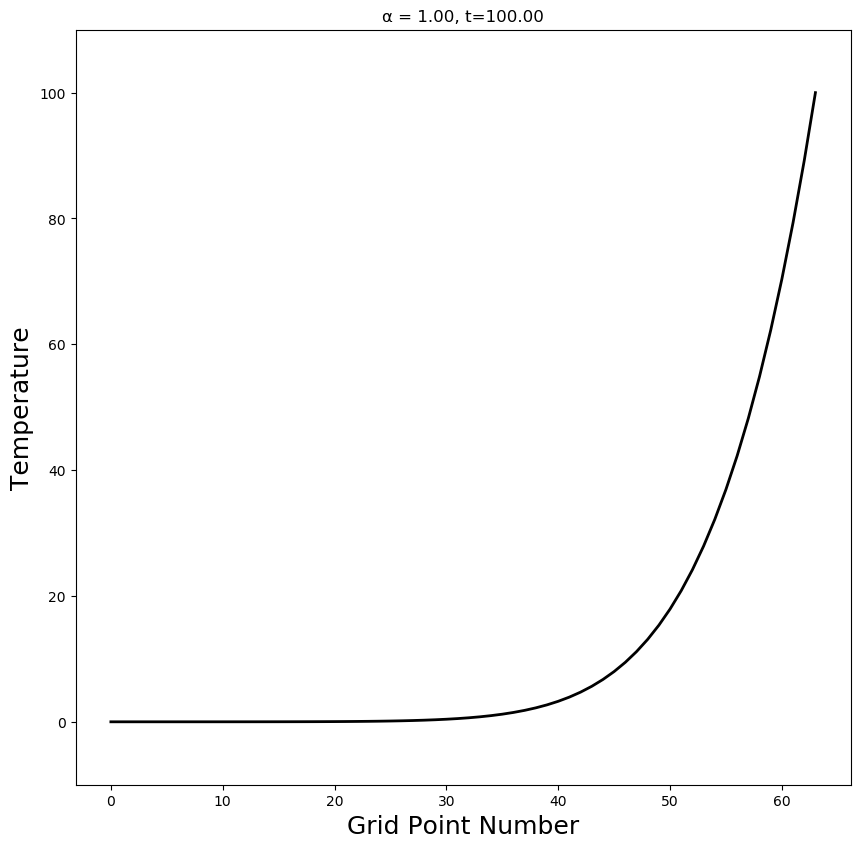

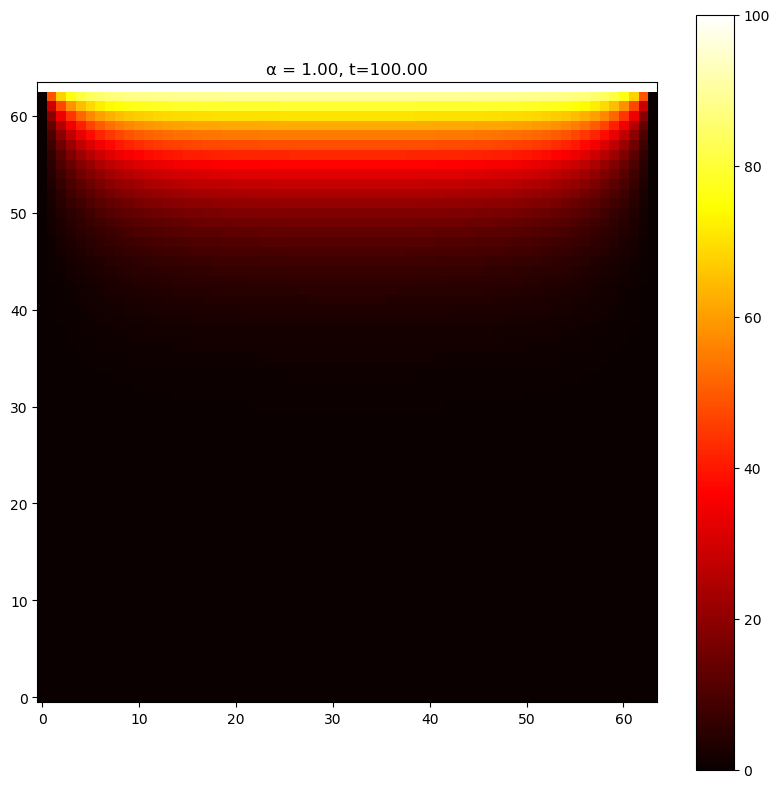

In [33]:
animate_heat(T_list,n_heat,α_init,0.1)

Cool, looking at our solution everything looks reasonable. We can see that the side of our wall heats up and the heat diffuses through the grid while all the boundaries are kept constant. Note we have choice in several constants: $\beta$, $\alpha$, and our stepsize $\Delta t$. In the regime of constants we've chosen, heat does not diffuse particularly quickly throughout the box. however, we can imagine two extreme scenarios: a scenario where heat travels very quickly, and our box almost immediately reaches an equilibrium with the heated boundary, and a scenario where heat diffuses very slowly, and nothing in the box really changes. Let's try using more extreme values of $\alpha$ and make animations to show this.

In [34]:
α_slow = 0.001
T_list_slow = heat_solver(T_ic, α=α_slow, niter=1000)

Starting to make animations...
1D animation finished!
2D animation finished!


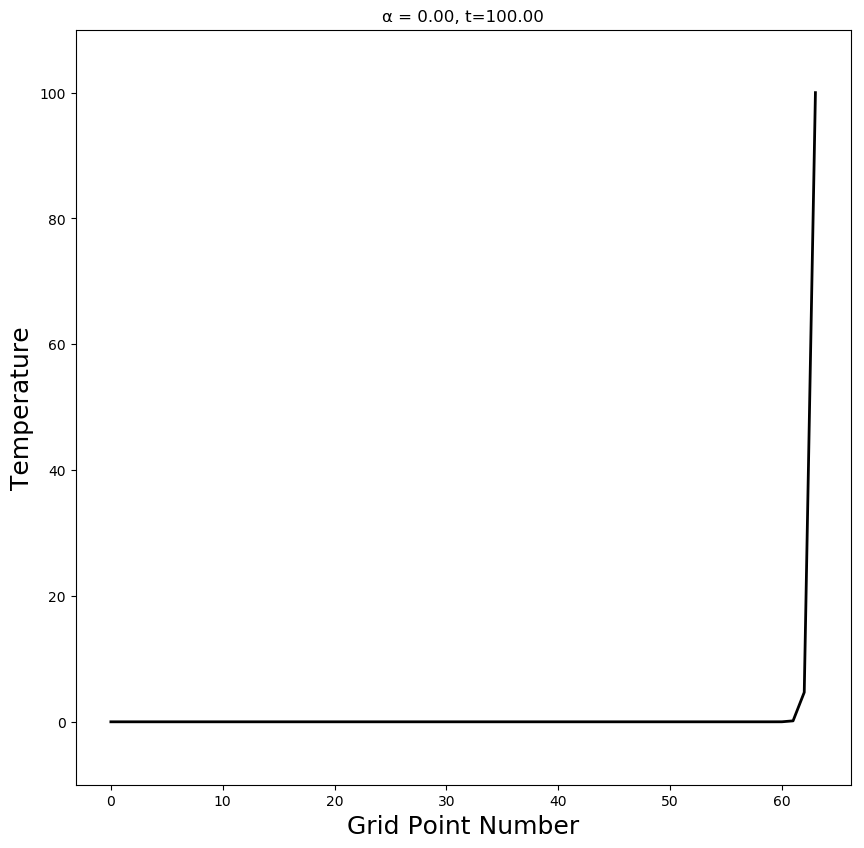

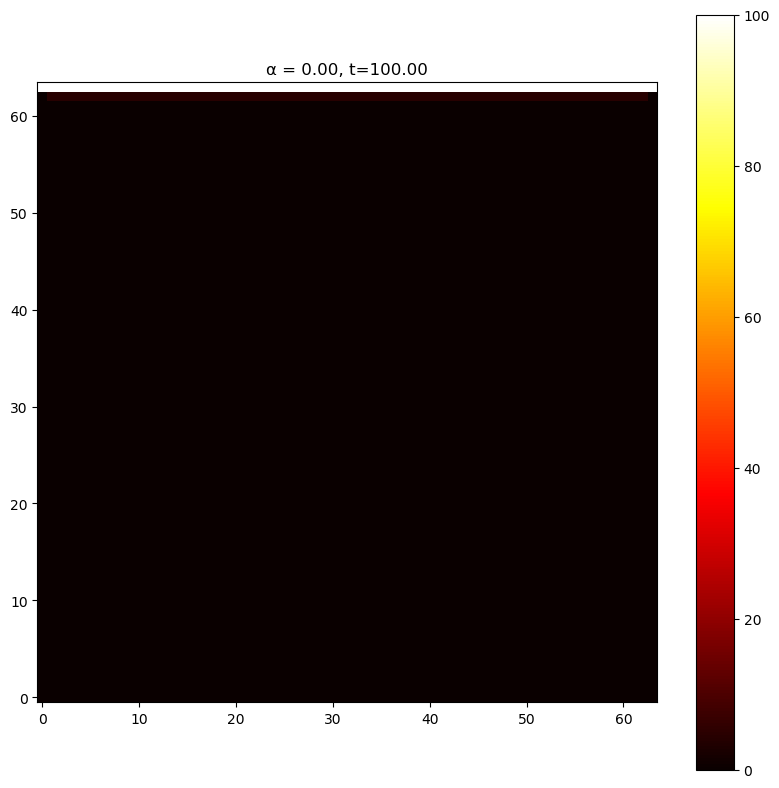

In [35]:
animate_heat(T_list_slow,n_heat,α_slow,0.1)

In [36]:
α_fast = 2.5 #as large as we can go
T_list_fast = heat_solver(T_ic, α=α_fast, niter=1000)

Starting to make animations...
1D animation finished!
2D animation finished!


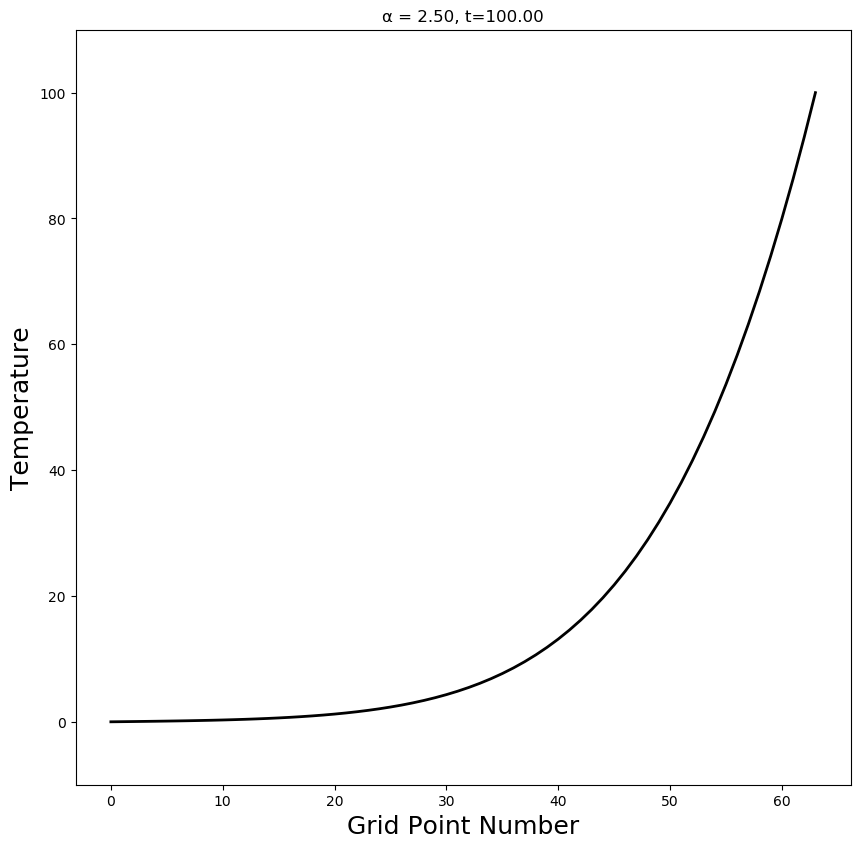

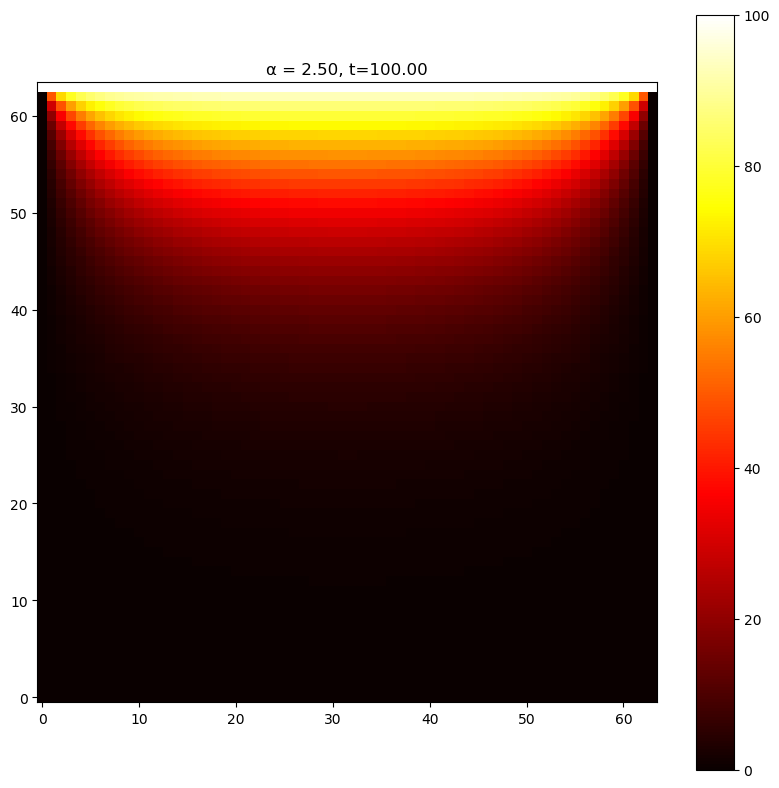

In [37]:
animate_heat(T_list_fast,n_heat,α_fast,0.1)